# Model Optimisation

## Overview

In this session, we will focus on *model optimisation* - i.e. how you can choose the best hyperparameters for your model. 

We will cover:
- The motivation for model optimisation
- Different methods for hyperparamer selection:
  - Grid search
  - Random search
  - Sequential search

## Recap of model hyperparameters

Every ML algorithm you come across has a number of hyperparameters, which control how the model fits to the data. 

Example hyperparameters include:
* The maximum depth in a decision tree
* The distance criteria in K-nearest neighbours
* The regularisation type (L1/L2) and strength (C) in logistic regression

Some algorithms (e.g. linear regression) have only a few hyperparameters. 

Others (e.g. Random Forest) may have lots!

The structure of a neural network (which you may not have come across) can also be considered as hyperparameters, e.g. the number of *hidden layers*, the number of *nodes* in each hidden layer, and the *activation function* in each layer!

## The motivation for model optimisation

Typically, our goal in supervised learning is to try and create the *best model* for a particular task. 

This can be thought of as two separate questions:
* Model selection: Which model or algorithm is best?
* Model optimisation: Which set of model hyperparameters are best?

In order to get the best final model, we need to select the best algorithm with the best corresponding set of hyperparameters!

*Note:* There are other steps in the ML pipeline we can try to optimise, more on that in a bit!

## Defining performance

*Best* could mean lots of different things:
* the highest accuracy on out of sample data,
* the lowest computational cost,
* the most interpretable, or
* some combination of all of these!

Whatever our definition of best is, as long as we can *quantify* it, we can try to optimise for it!

*Note:* we will either try to maximise it if it is a good thing (i.e. a **score**, e.g. accuracy) or minimise it if it is a bad thing (i.e. a **loss**, **error** or  computational **time** or **cost**).

For the rest of this session, we will assume we are trying to *maximise* a *score*, but all the lessons hold for any quantifiable metric of performance!

## Hyperparameter selection - a goal

Now we have our necessary elements, we can define our goal for hyperparameter selection:

* Find the set of model hyperparameters for a model algorithm that maximise the score (or minimise the loss) achieved in model evaluation



## The need to search

Formally, our goal for hyperparameter selection actually contains two optimisation loops.

We choose our hyperparameters in the *outer loop*. However, in order to evaluate the performance of the hyperparameters, we also need to fit the model, e.g. finding linear regression weights using gradient descent. This is the *inner loop*. 

As such, we can not *directly optimise* our model hyperparameters. Instead, we need to perform a search - where we test different values and choose the best ones!

As such, hyperparameter selection is often referred to as hyperparameter search!


## Our case study

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from bayes_opt import BayesianOptimization

import scipy.stats as st

We will be using the **The Iris Dataset** which can be loaded through sklearn.

The Iris dataset was used in R.A. Fisher's classic 1936 paper, The Use of Multiple Measurements in Taxonomic Problems, and can also be found on the UCI Machine Learning Repository.

It includes three iris species with 50 samples each as well as some properties about each flower. One flower species is linearly separable from the other two, but the other two are not linearly separable from each other.

The columns in this dataset are:

- Id
- SepalLengthCm
- SepalWidthCm
- PetalLengthCm
- PetalWidthCm
- Species

In [ ]:
#Loading the dataset
x = load_iris()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["Species"] = x.target
X = df.drop("Species", axis=1)   #Feature Matrix
y = df["Species"]          #Target Variable
df.head()

# Hyperparameter optimisation

**Hyperparameter optimisation** (or **hyperparameter selection** or **search**) refers to performing a search in a **hyperparameter space** with a purpose of discovering the set of specific model configurations (arguments) that result in the **best performance** of that model for a specific dataset.

The *hyperparameter space* is the space covered by all possible values of our hyperparameters, in the same way our *feature space* is the space covered by all possible values of each feature.

In [ ]:
# Example hyperparameters
rfc = RandomForestClassifier(n_estimators=100, max_depth=5)

## Why do we do this?

We perform the optimisation because the choice of the hyperparameters is as important as the choice of the ML model itself. Hence, poor choice of the hyperparameters will result in sub-optimal prediction/learning outcomes.

As we have established, we can't directly optimise hyperparameters, and so need to perform a search. 

The most obvious way to perform this search is **manually** - i.e. *manual search*. 

This is a laborious endeavour and takes a considerable amount of time, plus it is prone to mistakes, biases, or not searching the model hyperparameter space consistently. 

Surely there is a better way!

## Automated search

Thankfully, there are lots of automated ways of exploring the hyperparameter space, including:

- Grid search
- Random search
- Bayesian search

We will talk about each of these in turn, explaining each of their advantages and disadvantages. 

## But first, a recap on cross validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called **k-fold cross-validation**. It gives a robust way of evaluating model performance when optimising its hyperparameters.

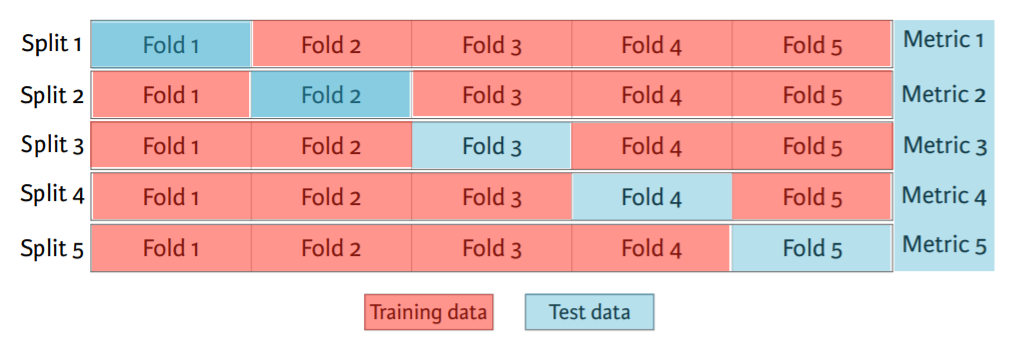

## Example without cross-validation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

clf = RandomForestClassifier(n_estimators=100, max_depth=5).fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(score)

## Example with cross-validation

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5)
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}")

### Cross-validation has its own hyperparameters!

In [ ]:
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores

## Grid search

Grid search predefines possible values for each parameter, and then exhaustively searches each possible combination of these values. 


This is implemented in scikit-learn as **GridSearchCV**, which exhaustively generates candidates from a grid of parameter values specified with the **param_grid parameter**, performing cross-validation on each combination.

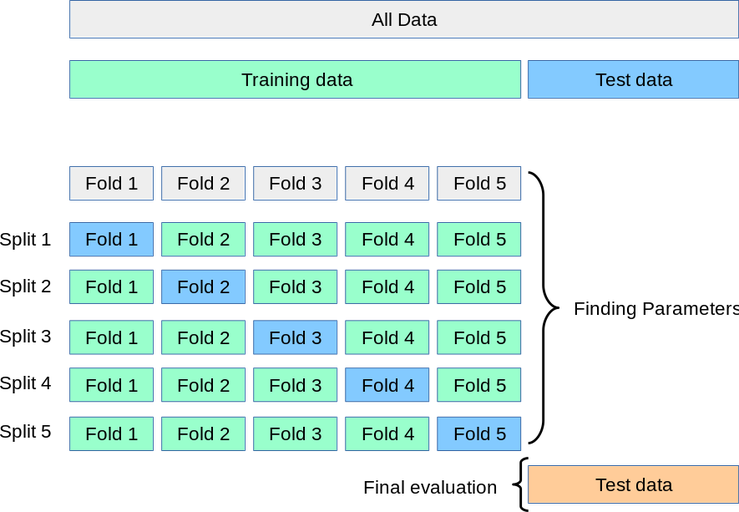

For instance, the following param_grid...

*Note:* We can see all of the possible hyperparameters using `??RandomForestClassifier`

In [ ]:
param_grid = [
  {'n_estimators': [10, 50, 100, 200], 'criterion': ['gini', 'entropy']},
  {'n_estimators': [10, 50, 100, 200], 'max_depth': [3, 5, 7], 'criterion': ['gini']},
 ]

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), param_grid)
clf = clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
clf.best_estimator_.score(X_test, y_test)

## Advantages of grid search

- Trivially simple
- Easy to parallelise
- Completely repeatable - if you share your grid definition with someone else, they should get exactly the same results!
- Easy to add new values or pick up where you left off

## Disadvantages of grid search

- Need to define suitable values for each parameter
- Inefficient - complexity scales exponentially with number of hyperparameters
- Only tests a small number of different values for each hyperparameter 
- Do not learn from previous searches - wastes time testing combinations that are unlikely to perform well

## Random search

In contrast to **GridSearchCV**, not all parameter values are tried out, but rather a **fixed number** of parameter settings is **sampled** from the **specified distributions**. The number of parameter configurations that are evaluated is given by **n_iter**.

Implemented in scikit-learn as `RandomizedSearchCV`

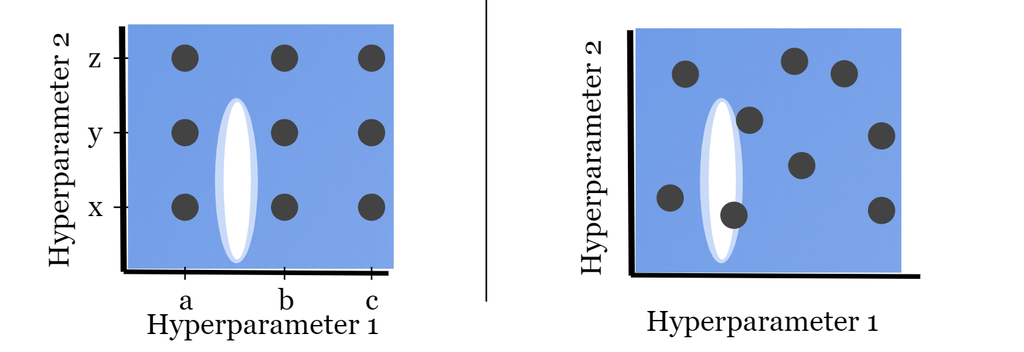

In [ ]:
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
distributions = dict(C=st.loguniform(0.001,100), penalty=['l2', 'l1'], fit_intercept=[True, False])

clf = RandomizedSearchCV(logistic, distributions, random_state=0, n_iter=500)
clf.fit(X_train, y_train)
clf.best_params_

In [ ]:
# investigate the values chosen
param_values = clf.cv_results_['params']
pd.Series([p['penalty'] for p in param_values]).value_counts()

In [ ]:
sns.ecdfplot([p['C'] for p in param_values])

In [ ]:
clf.best_estimator_.score(X_test, y_test)

### Advantages of random search

- Quite simple, conceptually
- *VERY* easy to parallelise!
- Relatively repeatable - if you share your distributions with someone else, they should get similar results!
- Easy to add new values or pick up where you left off
- Tests lots of values for each parameter
- Efficient - complexity scales linearly with number of trials (does not depend on number of tested hyperparameters)

### Drawbacks of random search

- Need to define suitable distributions for each parameter
- Less repeatable than GridSearch - even if you search using the same set random distributions, you will get different results each time (unless you have the same seed)
- No guarantees of coverage of the hyperparameter space
- Does not learn from previous searches - wastes time testing combinations that are unlikely to perform well

## Sequential search

Both grid search and random search had no way of *learning* from previous guesses or combinations of hyperparameters. 

We can therefore improve on them by making guesses *sequentially*, learning from previous tests. 

There are lots of ways to do this, but one popular one we will focus on here is *Bayesian search*.


### Bayesian inference 

At its core Bayesian search uses Bayesian inference, a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. Bayesian inference is an important technique in statistics, and especially in mathematical statistics.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

model = lambda x: x * np.sin(x)
X = np.array([1, 3, 5, 6, 8])
y = model(X)
xfit = np.linspace(0, 10, 1024)

gpr = GaussianProcessRegressor(alpha=1e-4)
gpr.fit(X.reshape(-1, 1), y)
yfit, std = gpr.predict(xfit.reshape(-1, 1), return_std=True)
se = ((model(xfit) - yfit)**2)
dyfit = std * 1.96
me = se.mean()

### Gaussian Process - example

In [ ]:
#The model fitting is performed under the hood of the slides.

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(X, y, 'or', label='observations')
ax.plot(xfit, yfit, '-', color='steelblue', label='prediction')
ax.plot(xfit, model(xfit), '-', color='red', alpha=0.5, label='$f(x) = x \cdot sin(x)$')
ax.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='gray', alpha=0.2, label='95% confidence')
ax.legend(loc='upper left')
me

## Bayesian hyperparameter search

Scikit-optimize provides a drop-in replacement for sklearn.model_selection.GridSearchCV, which utilizes **Bayesian Optimization** where a predictive model referred to as **“surrogate”** is used to model the hyperparameter search space and utilised to arrive at good parameter values mixtures as soon as possible. 

As we can't use scikit-optimize because of its poor sklearn version coverage, we will use **BayesianOptimization** from the **bayesian-optimization** package, which you can find [here](https://github.com/fmfn/BayesianOptimization). They work the same, the only difference being that we have to create some wrapper code so that it interfaces nicely with the scikit-learn API.

In [ ]:
def etrees_crossval(n_estimators,
                    max_features,
                    min_samples_split, 
                    min_samples_leaf,
                    max_samples):
    
    etrees = ExtraTreesClassifier(n_estimators=int(n_estimators),
                                  max_features=int(max_features),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  max_samples=float(max_samples),
                                  bootstrap=True,
                                  n_jobs=-1,
                                  verbose=0)
     
    mean_cv_score = cross_val_score(etrees, X_train, y_train, scoring=None, 
                                    cv=5, n_jobs=-1).mean()
     
    return mean_cv_score

The function evaluates the ExtraTreesClassifier with the stated hyperparameters on the training dataset

In [ ]:
etrees_crossval(10, 3, 2, 1, 0.99)

### Bayesian hyperparameter search - example
The optimiser requires the hyperparameter ranges we want to inspect

In [ ]:
optimizer = BayesianOptimization(f=etrees_crossval,
                                pbounds={'n_estimators': (25, 500),
                                         'max_features': (1, 4),
                                         'min_samples_split': (2, 30),
                                         'min_samples_leaf': (1, 14),
                                         'max_samples': (0.6, 0.99)},
                                         random_state=1234,
                                         verbose=2)

In [ ]:
optimizer.maximize(init_points=5,
                   n_iter=3)
 
print('nbest result:', optimizer.max)

### Advantages of Bayesian search

- Learns from previous searches - balances out the need to explore different values with exploring the subspaces we expect to perform well in detail
- Tests lots of values for each parameter
- Efficient - the quality of the guesses should improve with time
- Can "pick up where you left off" by using pickle to store the search object

### Drawbacks of Bayesian search

- Much more conceptually complex
- Sequential - difficult to parallelise (though the cross-validation can still be parallelised easily!)
- Less repeatable than GridSearch - can get stuck in local optima

## Beyond model hyper-parameters

So far in this lesson, we have focused on optimising ML model hyperparameters. However, we can use the same process to optimise different processes in the ML pipeline, using the `pipeline` class in scikit-learn. 

The pipeline interface effectively allows us to define hyperparameters that control:
* data preprocessing,
* feature engineering,
* feature selection, and
* model ensembling. 

We can then try to optimise all of these at once in a complex search, using either `GridSearchCV`, `RandomizedSearchCV`, or `BayesianOptimization` in scikit-learn!